# Bayesian Statistics

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import warnings
warnings.filterwarnings('ignore')

In [15]:
def simdata(t, x0,v0, a0):
    """Simulates data which gives final position of particle based on initial position, velocity and acceleration
    
    Parameters
    ----------
    
    t : Array, List
        Time taken for travel
        
    x0 : float
        Initial Position
        
    v0 : float
        Initial velocity
        
    a0 : float
        constant acceleration
        
    Returns
    -------
    
    xs : Array
        Position of particle"""
    ts = np.asarray(t)
    xs = x0 + v0*ts + 0.5*a0*ts**2
    return xs   


In [16]:
ts = np.arange(0, 3.0, 0.2)
x0 = 0; v0 = 24 ; a0 = 6; dx = 4.0; #measuring uncertainity
xs = simdata(ts, x0,v0,a0)
uncert = np.random.normal(scale = dx, size = len(ts))
x_dat = xs + uncert
x_dat[0] = 0 # as it is defined as x0 = 0

Text(0, 0.5, 'position (cm)')

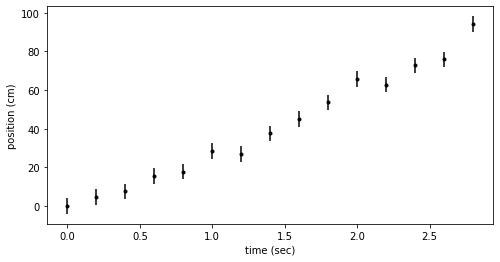

In [17]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.errorbar(ts, x_dat, yerr=dx, fmt=".k")
ax.set_xlabel('time (sec)')
ax.set_ylabel('position (cm)')


In [18]:
def postprob(v, dat):
    """
    Posterior Probability is prior times likelihood. Here we take gaussian likelihood and uniform prior v within range [0,50]
    
    Parameters
    ----------
    
    v : velocity of particles in range [0,50] """
    N = len(dat)
    if v<0 or v>50:
        return 0
    else:
        prior = 1/50
    mod = simdata(ts, 0, v, 0)
    likelihood = (1/(np.sqrt(2*np.pi)*dx))*np.exp(-0.5*(np.sum((dat - mod)**2)/dx**2))
    return prior * likelihood

In [19]:
vs = np.linspace(0,50,200)
integrand = [postprob(v,x_dat) for v in vs]
pline = scipy.integrate.simps(integrand, vs)

In [20]:
pline

1.1767197111480666e-07

In [21]:
pdf = integrand/pline #normalization

dv = vs[1] - vs[0]
cdf = np.cumsum(pdf)*dv
idx = cdf.searchsorted([0.5, 0.05, 0.95])
v_med, v_5, v_95 = vs[idx]
print("median = {0:.2f},  90% CI = ({1:.2f} - {2:.2f})".format(v_med, v_5, v_95))
bestfit = simdata(ts, x0=0, v0=v_med, a0=0)

median = 29.90,  90% CI = (28.89 - 30.90)


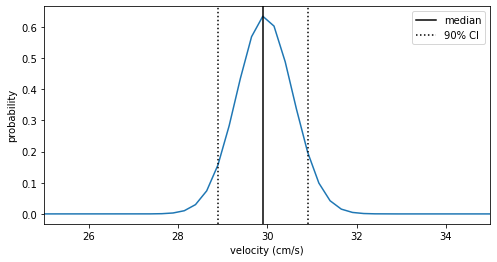

In [22]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)
ax1.plot(vs, pdf)
ax1.set_xlabel("velocity (cm/s)")
ax1.axvline(x=v_med, color = 'k', label='median')
ax1.axvline(x=v_5, color = 'k', linestyle=':', label=r'90% CI')
ax1.axvline(x=v_95, color = 'k', linestyle=':')
ax1.set_ylabel('probability')
ax1.set_xlim([25, 35])
ax1.legend()


Text(0, 0.5, 'position (cm)')

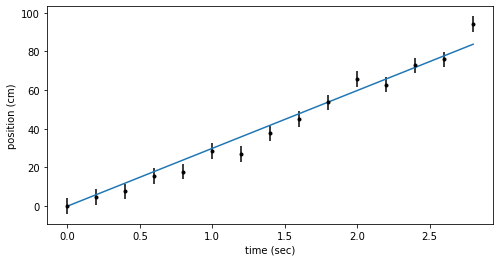

In [23]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.errorbar(ts, x_dat, yerr=dx, fmt=".k")
ax.plot(ts, bestfit, color='C0')
ax.set_xlabel('time (sec)')
ax.set_ylabel('position (cm)')


In [24]:
def quad_posterior(params , data):
    """Posterior Probability for two parameters v and a where v [0,50] and a [-5,15]
    """
    N = len(data)
    v,a  = params
    if v<0 or v>50 or a<-5 or a>15:
        return 0
    else:
        prior = 1/50 * 1/20
        
    mod = simdata(ts, 0, v, a)
    likelihood = (1/(np.sqrt(2*np.pi)*dx))*np.exp(-0.5*(np.sum((data - mod)**2)/dx**2))
    return prior * likelihood
    

In [25]:
vs = np.linspace(0,50,200)
As = np.linspace(-15,50,200)
prob = np.zeros([len(vs),len(As)])
for i, v in enumerate(vs):
    for j, a in enumerate(As):
        prob[i,j] = quad_posterior([v,a],x_dat)
inta = scipy.integrate.simps(prob, x = As, axis=0)
intv = scipy.integrate.simps(inta, x = vs)
pquad = intv
pquad

6.6516572092645905e-06

Text(0, 0.5, 'velocity (cm/s)')

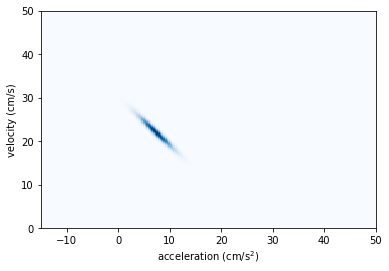

In [26]:
plt.pcolormesh(As, vs, prob, cmap='Blues')
plt.xlabel("acceleration (cm/s$^2$)")
plt.ylabel("velocity (cm/s)")


In [27]:
apost = scipy.integrate.simps(prob, x=As, axis=0)
vpost = scipy.integrate.simps(prob, x=vs, axis=1)

a_cdf = np.cumsum(apost) / np.sum(apost)  # normalize
v_cdf = np.cumsum(vpost) / np.sum(vpost)

idx_a = a_cdf.searchsorted([0.5, 0.05, 0.95])
idx_v = v_cdf.searchsorted([0.5, 0.05, 0.95])

a_med, a_5, a_95 = As[idx_a]
v_med, v_5, v_95 = vs[idx_v]
print("accel: median = {0:.2f},  90% CI = ({1:.2f} - {2:.2f})".format(a_med, a_5, a_95))
print("vel: median = {0:.2f},  90% CI = ({1:.2f} - {2:.2f})".format(v_med, v_5, v_95))

bestfit_quad = simdata(ts, x0=0, v0=v_med, a0=a_med)


accel: median = 7.21,  90% CI = (3.62 - 11.13)
vel: median = 22.11,  90% CI = (17.84 - 26.13)


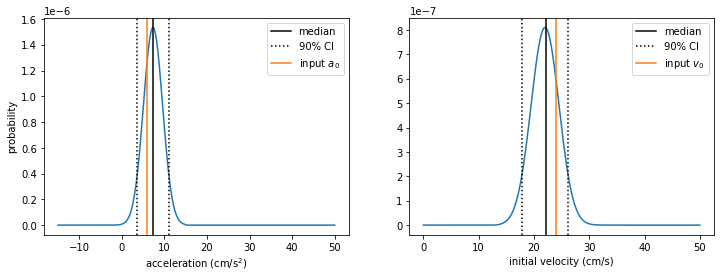

In [28]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.plot(As, apost)
ax1.set_xlabel("acceleration (cm/s$^2$)")
ax1.axvline(x=a_med, color = 'k', label='median')
ax1.axvline(x=a_5, color = 'k', linestyle=':', label=r'90% CI')
ax1.axvline(x=a_95, color = 'k', linestyle=':')
ax1.axvline(x=a0, color = 'C1', label='input $a_0$')
ax1.set_ylabel('probability')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(vs, vpost)
ax2.set_xlabel("initial velocity (cm/s)")
ax2.axvline(x=v_med, color = 'k', label='median')
ax2.axvline(x=v_5, color = 'k', linestyle=':', label=r'90% CI')
ax2.axvline(x=v_95, color = 'k', linestyle=':')
ax2.axvline(x=v0, color = 'C1', label='input $v_0$')
ax2.legend()


Text(0, 0.5, 'position (cm)')

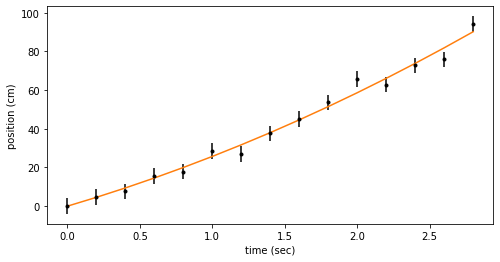

In [29]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.errorbar(ts, x_dat, yerr=dx, fmt=".k")
ax.plot(ts, bestfit_quad, color='C1')
ax.set_xlabel('time (sec)')
ax.set_ylabel('position (cm)')


In [30]:
BF = pquad/pline
prob = 1/(1 + 1/BF)
print("Odds = {0:.0f};  prob = {1:.4f}".format(BF, prob))


Odds = 57;  prob = 0.9826
